# Sandbox Jupyter Notebook for Source2Suffering

Modules needed that can be load with Jupyter Lab

- xarray
- cartopy
- openpyxl

Modules needed that can't be load with Jupyter Lab

- mapclassify 2.4.3
   - Provide in geopandas/0.12.2-foss-2022a
         - Works if we load geopandas from Jupyter Lab

---

Change path to current directory path

In [1]:
import os

notebook_path = os.getcwd()  # Current path
print("Directory of the notebook:", notebook_path)
notebook_path = notebook_path

scripts_dir = "/data/brussel/vo/000/bvo00012/vsc11137/source2suffering"
data_dir = scripts_dir+"/data/"

Directory of the notebook: /vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc11137/source2suffering/notebooks


Libraries

In [2]:
#%%  ----------------------------------------------------------------
# import and path
# ----------------------------------------------------------------

import xarray as xr
import pickle as pk
import time
# from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import mapclassify as mc
from copy import deepcopy as cp
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy as cr
import geopandas as gpd
import sys
from operator import index
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy import stats as sts
import regionmask as rm
import glob

sys.path.append(os.path.abspath(scripts_dir))

## Visualization of objects

### exposure_trends{extr}

In [3]:
with open(data_dir+'{}/{}/lifetime_exposure_trends_regions.pkl'.format('pickles_S2S_v1','heatwavedarea'), 'rb') as f:
            ds_le_trends_regions=pk.load(f)   

In [4]:
ds_le_trends_regions

<xarray.Dataset>
Dimensions:                      (run: 12, GMT: 21, region: 46, year: 61,
                                  country: 177, basin: 220)
Coordinates:
  * region                       (region) int64 0 1 2 3 4 5 ... 41 42 43 44 45
  * country                      (country) int64 0 1 2 3 4 ... 173 174 175 176
  * basin                        (basin) int64 0 1 2 3 4 ... 221 222 223 224 225
  * run                          (run) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * GMT                          (GMT) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20
  * year                         (year) int64 1960 1961 1962 ... 2018 2019 2020
Data variables:
    exposure_trend_ar6           (run, GMT, region, year) float64 nan ... nan
    mean_exposure_trend_ar6      (GMT, region, year) float64 nan nan ... nan nan
    exposure_trend_country       (run, GMT, country, year) float64 nan ... nan
    mean_exposure_trend_country  (GMT, country, year) float64 nan nan ... nan
    exposure_trend_basin         (run, GMT, basin, year) float64 nan nan ... nan
    mean_exposure_trend_basin    (GMT, basin, year) float64 nan nan ... nan nan

In [5]:
value = ds_le_trends_regions['exposure_trend_ar6'].sel(
    run=2,
    GMT=5,
    region=10,
    year=2020
)

print(value)

<xarray.DataArray 'exposure_trend_ar6' ()>
array(nan)
Coordinates:
    region   int64 10
    run      int64 2
    GMT      int64 5
    year     int64 2020


In [6]:
print(ds_le_trends_regions['exposure_trend_ar6'].sel(
    run=11,
    GMT=20,
    region=25,
))

<xarray.DataArray 'exposure_trend_ar6' (year: 61)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    region   int64 25
    run      int64 11
    GMT      int64 20
  * year     (year) int64 1960 1961 1962 1963 1964 ... 2016 2017 2018 2019 2020


In [7]:
# Vérifier si la variable 'exposure_trend_ar6' existe dans le dataset
if 'exposure_trend_ar6' in ds_le_trends_regions:

    # Créer un masque booléen où True indique que la valeur n'est pas NaN
    mask_non_nan = ds_le_trends_regions['exposure_trend_ar6'].notnull()

    # Vérifier s'il existe des valeurs non-NaN dans toutes les dimensions et coordonnées
    all_non_nan = mask_non_nan.all()

    # Afficher le résultat
    if all_non_nan:
        print("Toutes les coordonnées ont des valeurs non nulles et différentes de NaN.")
    else:
        print("Certaines coordonnées contiennent des valeurs NaN ou nulles.")
else:
    print("La variable 'exposure_trend_ar6' n'existe pas dans le dataset.")


Certaines coordonnées contiennent des valeurs NaN ou nulles.


### da_regions

In [8]:
d_countries = pk.load(open(data_dir+'{}/country/country_info.pkl'.format('pickles_S2S_v1'), 'rb'))
df_countries = d_countries['info_pop']

In [9]:
da_regions = df_countries['region'].unique()

In [10]:
da_regions

array(['South Asia', 'Sub-Saharan Africa', 'Europe & Central Asia',
       'Middle East & North Africa', 'Latin America & Caribbean',
       'East Asia & Pacific', 'North America'], dtype=object)

### isimip_meta

In [11]:
with open(data_dir+'{}/{}/isimip_metadata_{}_{}_{}.pkl'.format('pickles_S2S_v1','heatwavedarea','heatwavedarea','original','rm'), 'rb') as f:
            d_isimip_meta_original=pk.load(f)   

with open(data_dir+'{}/{}/isimip_metadata_{}_{}_{}.pkl'.format('pickles_S2S_v1','heatwavedarea','heatwavedarea','ar6_new','rm'), 'rb') as f:
            d_isimip_meta_ar6_new=pk.load(f)   

In [12]:
print(d_isimip_meta_original[1]['GMT'])

           tas
1960  0.160412
1961  0.164745
1962  0.170719
1963  0.192197
1964  0.197078
...        ...
2109  1.318585
2110  1.317312
2111  1.317312
2112  1.317312
2113  1.317312

[154 rows x 1 columns]


In [13]:
print(d_isimip_meta_ar6_new)

{1: {'model': '/data/brussel/vo/000/bvo00012/vsc11137/source2suffering/data/isimip/heatwavedarea/hwmid99/hwmid99', 'gcm': 'gfdl-esm2m', 'rcp': 'rcp26', 'extreme': 'heatwavedarea', 'GMT':            tas
1960  0.160412
1961  0.164745
1962  0.170719
1963  0.192197
1964  0.197078
...        ...
2109  1.318585
2110  1.317312
2111  1.317312
2112  1.317312
2113  1.317312

[154 rows x 1 columns], 'GMT_15_maxdiff': 0.10586686141942314, 'GMT_20_maxdiff': 0.6384957019586501, 'GMT_NDC_maxdiff': 1.04115532405292, 'GMT_R26eval_maxdiff': 0.0, 'GMT_OS_maxdiff': 0.4656358543417862, 'GMT_noOS_maxdiff': 0.1656358543417873, 'GMT_STS_ModAct_maxdiff': 1.313285854341786, 'GMT_STS_Ren_maxdiff': 0.18368585434178608, 'GMT_15_valid': True, 'GMT_20_valid': False, 'GMT_NDC_valid': False, 'GMT_R26eval_valid': True, 'GMT_OS_valid': False, 'GMT_noOS_valid': True, 'GMT_STS_ModAct_valid': False, 'GMT_STS_Ren_valid': True, 'ind_RCP2GMT_15': array([ 17,  16,  16,  15,   7,   2,   4,  13,  14,  10,  14,  16,  17,
        

### da_cohort_size and da_cohort_size_countries_2020

In [23]:
with open(data_dir + '{}/country/da_cohort_size.pkl'.format('pickles_S2S_v1'), 'rb') as f:
            da_cohort_size=pk.load(f)  

ages = np.arange(60,-1,-1)

print(da_cohort_size.sel(time=2020,ages=ages))

<xarray.DataArray (country: 177, ages: 61)>
array([[ 136.024,  143.616,  151.208, ..., 1269.02 , 1269.02 , 1269.02 ],
       [ 115.188,  121.072,  126.956, ..., 1063.92 , 1063.92 , 1063.92 ],
       [  39.864,   40.456,   41.048, ...,   32.24 ,   32.24 ,   32.24 ],
       ...,
       [ 397.456,  413.544,  429.632, ..., 1110.04 , 1110.04 , 1110.04 ],
       [  53.316,   56.764,   60.212, ...,  633.52 ,  633.52 ,  633.52 ],
       [  54.732,   57.308,   59.884, ...,  486.18 ,  486.18 ,  486.18 ]])
Coordinates:
  * country  (country) <U32 'Afghanistan' 'Angola' ... 'Zambia' 'Zimbabwe'
    time     int64 2020
  * ages     (ages) int64 60 59 58 57 56 55 54 53 52 51 ... 9 8 7 6 5 4 3 2 1 0


In [25]:
with open(data_dir + '{}/country/da_cohort_size_countries_2020.pkl'.format('pickles_S2S_v1'), 'rb') as f:
            da_cohort_size_countries_2020=pk.load(f)  

print(da_cohort_size_countries_2020.sel(country='Belgium'))

<xarray.DataArray (ages: 61)>
array([152092., 154748., 157404., 160060., 159712., 159364., 159016.,
       158668., 158320., 157144., 155968., 154792., 153616., 152440.,
       151784., 151128., 150472., 149816., 149160., 149312., 149464.,
       149616., 149768., 149920., 149356., 148792., 148228., 147664.,
       147100., 146384., 145668., 144952., 144236., 143520., 140416.,
       137312., 134208., 131104., 128000., 127392., 126784., 126176.,
       125568., 124960., 126292., 127624., 128956., 130288., 131620.,
       131464., 131308., 131152., 130996., 130840., 130500., 130160.,
       129820., 129480., 129140., 129140., 129140.])
Coordinates:
    country  <U32 'Belgium'
    time     int64 2020
  * ages     (ages) int64 60 59 58 57 56 55 54 53 52 51 ... 9 8 7 6 5 4 3 2 1 0


<xarray.DataArray ()>
array(47628.)
Coordinates:
    country  <U32 'Burundi'
    time     int64 2020
    ages     int64 60


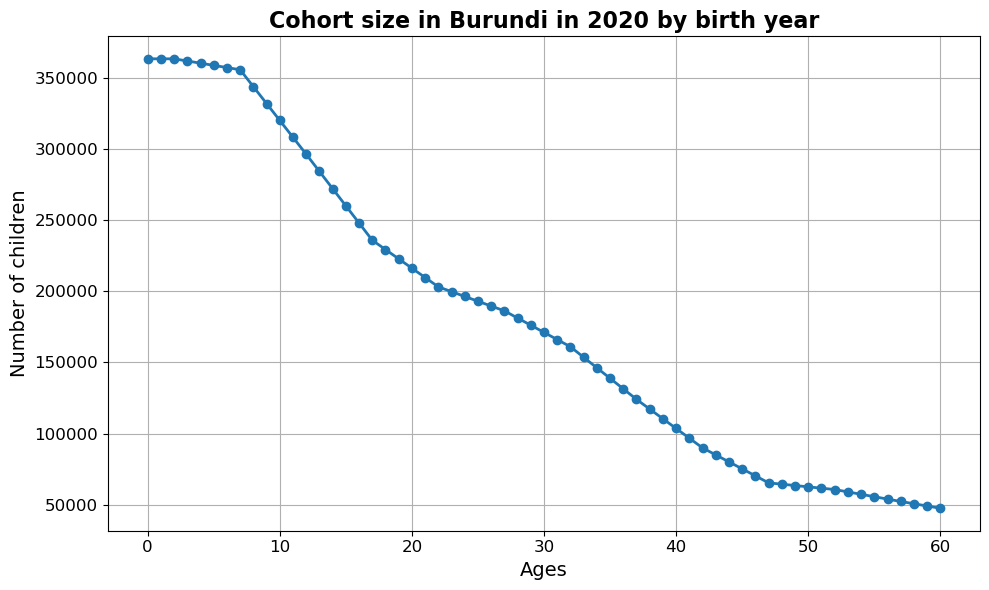

In [47]:
%matplotlib inline  

# Select the country
country = 'Burundi'
data = da_cohort_size_countries_2020.sel(country=country)

print(data.sel(ages=60))

# Plot
plt.figure(figsize=(10,6))
plt.plot(data.ages.values, data.values, marker='o', color='tab:blue', lw=2)

# Customize
plt.title(f'Cohort size in {country} in 2020 by birth year', fontsize=16, fontweight='bold')
plt.xlabel('Ages', fontsize=14)
plt.ylabel('Number of children', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### ds_regions

In [52]:
with open(data_dir + '{}/country/ds_regions.pkl'.format('pickles_S2S_v1'), 'rb') as f:
            ds_regions=pk.load(f)  

print(ds_regions['member_countries'])

<xarray.DataArray 'member_countries' (region: 12)>
array([list(['Australia', 'Brunei Darussalam', 'China', 'Fiji', 'Hong Kong', 'Indonesia', 'Japan', 'Cambodia', 'Kiribati', 'Republic of Korea', 'Lao PDR', 'Myanmar', 'Mongolia', 'Malaysia', 'New Caledonia', 'New Zealand', 'Philippines', 'Papua New Guinea', 'Dem. Rep. Korea', 'French Polynesia', 'Solomon Islands', 'Thailand', 'Timor-Leste', 'Vietnam', 'Vanuatu', 'Samoa']),
       list(['Albania', 'Armenia', 'Austria', 'Azerbaijan', 'Belgium', 'Bulgaria', 'Bosnia and Herzegovina', 'Belarus', 'Switzerland', 'Cyprus', 'Czech Republic', 'Germany', 'Denmark', 'Spain', 'Estonia', 'Finland', 'France', 'United Kingdom', 'Georgia', 'Greece', 'Croatia', 'Hungary', 'Ireland', 'Iceland', 'Italy', 'Kazakhstan', 'Kyrgyzstan', 'Lithuania', 'Luxembourg', 'Latvia', 'Moldova', 'Macedonia', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russian Federation', 'Serbia', 'Slovakia', 'Slovenia', 'Sweden', 'Tajikistan', 'Turkmenistan',

## Lifetime Exposure (LE)

### ds_le_percountry_perrun_gmt_original

### ds_le_perregion_perrun_gmt_original

### ds_le_perregion_gmt_original

### ds_le_percountry_ar6_new_rm

In [ ]:
file_path = data_dir + 'pickles_S2S_v1/heatwavedarea/ds_le_percountry_gmt_ar6_new_rm.pkl'
with open(file_path, 'rb') as f: ds_le_percountry=pk.load(f) 

print(ds_le_percountry['std_BE'].sel(country='Japan', GMT=0, birth_year=1960))

<xarray.DataArray 'std_BE' ()>
array(2.22585686)
Coordinates:
    country     <U5 'Japan'
    birth_year  int64 1960
    GMT         int64 0
    quantile    float64 0.25


### ds_le_percountry_perrun_BE and d_cohort_weights_regions

In [ ]:
with open(data_dir+'{}/{}/ds_le_percountry_perrun_gmt_{}_{}.pkl'.format('pickles_S2S_v1','heatwavedarea','original','no_rm'), 'rb') as f:
            ds_le_percountry_perrun = pk.load(f)

with open(data_dir + '{}/country/ds_regions.pkl'.format('pickles_S2S_v1'), 'rb') as f:
            ds_regions = pk.load(f)

region_ind = 9

member_countries = ds_regions['member_countries'].sel(region=region_ind).values.tolist()

print(member_countries)

i = 2
step = 6

le_percountry_perrun_BE = ds_le_percountry_perrun['le_percountry_perrun_BE'].loc[{
                        'run': i,
                        'GMT': step,
                        'country': member_countries,
                        'birth_year': slice(None)
                    }]

print(np.shape(le_percountry_perrun_BE))
print(le_percountry_perrun_BE)

['Angola', 'Burundi', 'Benin', 'Burkina Faso', 'Botswana', 'Central African Republic', 'Cote dIvoire', 'Cameroon', 'Democratic Republic of the Congo', 'Republic of Congo', 'Comoros', 'Cape Verde', 'Eritrea', 'Ethiopia', 'Gabon', 'Ghana', 'Guinea', 'The Gambia', 'Guinea-Bissau', 'Equatorial Guinea', 'Kenya', 'Liberia', 'Lesotho', 'Madagascar', 'Mali', 'Mozambique', 'Mauritania', 'Mauritius', 'Malawi', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sudan', 'Senegal', 'Sierra Leone', 'Somalia', 'South Sudan', 'Sao Tome and Principe', 'Swaziland', 'Chad', 'Togo', 'Tanzania', 'Uganda', 'South Africa', 'Zambia', 'Zimbabwe']
(47, 61)
<xarray.DataArray 'le_percountry_perrun_BE' (country: 47, birth_year: 61)>
array([[ 0.69629713,  0.93699785,  0.97539423, ...,  6.26716846,
         6.22362889,  6.27317603],
       [ 0.71210575,  0.71210569,  0.71210575, ...,  1.96196103,
         1.96196103,  1.90217304],
       [ 1.50797701,  1.50797701,  1.50797701, ...,  4.61190128,
         4.61190128,  4.611901

In [ ]:
with open(data_dir + '{}/country/d_cohort_weights_regions.pkl'.format('pickles_S2S_v1'), 'rb') as f:
    d_cohort_weights_regions = pk.load(f)

region_name = 'Sub-Saharan Africa'

weights = d_cohort_weights_regions[region_name]

# print(np.shape(weights))
# print(weights.T)

print(np.shape(weights.values.T))
print(weights.values.T)

(47, 61)
[[ 136.024  143.616  151.208 ... 1269.02  1269.02  1269.02 ]
 [ 125.248  129.552  133.856 ...   82.42    82.42    82.42 ]
 [  47.628   49.212   50.796 ...  363.18   363.18   363.18 ]
 ...
 [ 730.384  754.776  779.168 ... 1257.34  1257.34  1257.34 ]
 [ 221.384  232.176  242.968 ... 2009.72  2009.72  2009.72 ]
 [ 123.164  130.496  137.828 ... 1695.1   1695.1   1695.1  ]]


In [ ]:
weighted_avg = np.nansum(le_percountry_perrun_BE.values * weights.values.T, axis=0) / np.nansum(weights.values.T, axis=0)
print(weighted_avg)

[ 3.34475979  3.41319484  3.4722034   3.52673088  4.00385622  4.17263442
  4.23333173  4.29940533  4.38230247  4.43137224  4.50876394  4.58601503
  4.66981666  4.96848014  5.58796194  6.1909896   6.77537736  7.33754892
  7.79475184  8.32092299  8.82077833  9.2749477   9.79071207 10.25318973
 10.86312961 11.4877152  12.08756403 12.66761516 13.28696848 13.16580964
 13.06640069 12.97637415 12.87489894 12.7352451  12.6507814  12.56813451
 12.46376197 12.37023273 12.30544107 12.32835391 12.33738176 12.38389864
 12.07469678 12.09484503 12.13937936 12.1949639  12.2727057  12.34581239
 12.41026664 12.45382758 12.73288508 13.29349013 13.83212156 14.42037625
 14.60140776 14.74621247 15.14364478 15.13978922 15.12945307 15.26439719
 15.41024749]


### Construction de da_cohort_size_regions à partir de da_cohort_size

In [ ]:
with open(data_dir + '{}/country/da_cohort_size.pkl'.format('pickles_S2S_v1'), 'rb') as f:
    da_cohort_size = pk.load(f)

da_cohort_size_mod = da_cohort_size.sel(country='Democratic Republic of the Congo',time=2020)

da_cohort_size_mod = da_cohort_size_mod.sel(ages=slice(60, 0))

print(da_cohort_size_mod)

<xarray.DataArray (ages: 61)>
array([ 331.768,  349.292,  366.816,  384.34 ,  404.172,  424.004,
        443.836,  463.668,  483.5  ,  505.664,  527.828,  549.992,
        572.156,  594.32 ,  620.404,  646.488,  672.572,  698.656,
        724.74 ,  756.42 ,  788.1  ,  819.78 ,  851.46 ,  883.14 ,
        919.916,  956.692,  993.468, 1030.244, 1067.02 , 1111.028,
       1155.036, 1199.044, 1243.052, 1287.06 , 1338.14 , 1389.22 ,
       1440.3  , 1491.38 , 1542.46 , 1611.928, 1681.396, 1750.864,
       1820.332, 1889.8  , 1971.604, 2053.408, 2135.212, 2217.016,
       2298.82 , 2385.768, 2472.716, 2559.664, 2646.612, 2733.56 ,
       2778.252, 2822.944, 2867.636, 2912.328, 2957.02 , 2957.02 ,
       2957.02 ])
Coordinates:
    country  <U32 'Democratic Republic of the Congo'
    time     int64 2020
  * ages     (ages) int64 60 59 58 57 56 55 54 53 52 51 ... 9 8 7 6 5 4 3 2 1 0


In [ ]:
ages = np.arange(60, -1, -1)
year_ref = 2020

def get_regions_cohort(df_countries, ds_regions, da_cohort_size):
    # Ensure 'ages' is in descending order and select the target range
    da_cohort_size = da_cohort_size.sel(time=year_ref)
    da_cohort_size = da_cohort_size.sel(ages=ages)  # safer than slice(60, 0)

    nregions = len(ds_regions['name'])

    # Initialize output DataArray with NaNs
    da_cohort_size_regions = xr.DataArray(
        np.full(
            (nregions, len(df_countries['name'].values), len(ages)),
            fill_value=np.nan
        ),
        dims=['region', 'country', 'ages'],
        coords={
            'region': ('region', np.arange(0, nregions)),
            'country': ('country', df_countries['name'].values),
            'ages': ('ages', ages)
        }
    )

    # Fill values per region
    for region_ind, region in enumerate(ds_regions.region.values):
        member_countries = ds_regions['member_countries'].sel(region=region_ind).values.tolist()

        # Ensure countries exist in the target DataArray
        available_countries = [c for c in member_countries if c in df_countries['name'].values]

        if available_countries:
            da_cohort_size_regions.loc[dict(
                region=region_ind,
                country=available_countries
            )] = da_cohort_size.sel(country=available_countries).values

    return da_cohort_size_regions

In [ ]:
with open(data_dir + '{}/country/df_countries.pkl'.format('pickles_S2S_v1'), 'rb') as f:
    df_countries = pk.load(f)

In [ ]:
da_cohort_size_regions = get_regions_cohort(df_countries, ds_regions, da_cohort_size)

print(da_cohort_size_regions.sel(region=8))

<xarray.DataArray (country: 177, ages: 61)>
array([[ 136.024,  143.616,  151.208, ..., 1269.02 , 1269.02 , 1269.02 ],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])
Coordinates:
    region   int64 8
  * country  (country) object 'Afghanistan' 'Angola' ... 'Zambia' 'Zimbabwe'
  * ages     (ages) int64 60 59 58 57 56 55 54 53 52 51 ... 9 8 7 6 5 4 3 2 1 0


In [ ]:
with open(data_dir + '{}/country/da_cohort_size_regions.pkl'.format('pickles_S2S_v1'), 'rb') as f:
    da_cohort_size_regions = pk.load(f)

print(da_cohort_size_regions.sel(country="Democratic Republic of the Congo",region=9)*1e3)

<xarray.DataArray (ages: 61)>
array([3.317680e+08, 3.492920e+08, 3.668160e+08, 3.843400e+08,
       4.041720e+08, 4.240040e+08, 4.438360e+08, 4.636680e+08,
       4.835000e+08, 5.056640e+08, 5.278280e+08, 5.499920e+08,
       5.721560e+08, 5.943200e+08, 6.204040e+08, 6.464880e+08,
       6.725720e+08, 6.986560e+08, 7.247400e+08, 7.564200e+08,
       7.881000e+08, 8.197800e+08, 8.514600e+08, 8.831400e+08,
       9.199160e+08, 9.566920e+08, 9.934680e+08, 1.030244e+09,
       1.067020e+09, 1.111028e+09, 1.155036e+09, 1.199044e+09,
       1.243052e+09, 1.287060e+09, 1.338140e+09, 1.389220e+09,
       1.440300e+09, 1.491380e+09, 1.542460e+09, 1.611928e+09,
       1.681396e+09, 1.750864e+09, 1.820332e+09, 1.889800e+09,
       1.971604e+09, 2.053408e+09, 2.135212e+09, 2.217016e+09,
       2.298820e+09, 2.385768e+09, 2.472716e+09, 2.559664e+09,
       2.646612e+09, 2.733560e+09, 2.778252e+09, 2.822944e+09,
       2.867636e+09, 2.912328e+09, 2.957020e+09, 2.957020e+09,
       2.957020e+09])
Coo

### Modification pipeline calc_lifetime_exposure() avec nouvel objet cohort des régions

In [ ]:
# with open(data_dir+'{}/{}/ds_le_percountry_perrun_gmt_{}_{}.pkl'.format('pickles_S2S_v1','heatwavedarea','original','no_rm'), 'rb') as f:
#     ds_le_percountry_perrun = pk.load(f)

# #print(ds_le_percountry_perrun)

# for i in range(12):

#     #---------------------------------------------------------------------#
#     # Per region                                                          #
#     #---------------------------------------------------------------------#

#     for region_ind, region in enumerate(ds_regions.region.values):

#         region_name = ds_regions['name'].sel(region=region_ind).item()
#         member_countries = ds_regions['member_countries'].sel(region=region_ind).values.tolist()

#         # Get the lifetime exposure per country for this region and run
#         le_percountry_perrun = ds_le_percountry_perrun['le_percountry_perrun_15'].loc[{
#             'run': i,
#             'country': member_countries,
#             'birth_year': slice(None)
#         }]

#         # Extract cohort size weights for region and member countries
#         da_weights = da_cohort_size_regions.sel(
#             region=region_ind,
#             country=member_countries
#         )

#         # Convert 'ages' (60→0) to 'birth_year' (1960→2020) assuming ref year = 2020
#         birth_years = 2020 - da_weights['ages'].values
#         da_weights = da_weights.assign_coords(birth_year=('ages', birth_years))
#         da_weights = da_weights.swap_dims({'ages': 'birth_year'}).sortby('birth_year')

#         # Now da_weights has shape (country, birth_year)
#         # Align both arrays to avoid misalignment issues
#         le_percountry_perrun, da_weights = xr.align(le_percountry_perrun, da_weights, join="exact")

#         # Compute weighted average over countries (dim=0)
#         weighted_avg = (le_percountry_perrun * da_weights).sum(dim='country', skipna=True) / \
#                     da_weights.sum(dim='country', skipna=True)

#         # Store result in the output dataset
#         ds_le_perregion_perrun['le_perregion_perrun_15'].loc[{
#             'run': i,
#             'region': region_ind,
#             'birth_year': slice(None)
#         }] = weighted_avg

### Construction de da_valp_cohort_size_abs à partir de da_cohort_size_regions

In [ ]:
da_valp_cohort_size_abs = da_cohort_size_regions.sum(dim="country", skipna=True)

#print(da_valp_cohort_size_abs)

print(da_valp_cohort_size_abs.sel(region=7))

<xarray.DataArray (ages: 61)>
array([4745588., 4786752., 4827916., 4869080., 4815128., 4761176.,
       4707224., 4653272., 4599320., 4574940., 4550560., 4526180.,
       4501800., 4477420., 4491084., 4504748., 4518412., 4532076.,
       4545740., 4606444., 4667148., 4727852., 4788556., 4849260.,
       4906316., 4963372., 5020428., 5077484., 5134540., 5160960.,
       5187380., 5213800., 5240220., 5266640., 5164036., 5061432.,
       4958828., 4856224., 4753620., 4710244., 4666868., 4623492.,
       4580116., 4536740., 4552976., 4569212., 4585448., 4601684.,
       4617920., 4581920., 4545920., 4509920., 4473920., 4437920.,
       4467452., 4496984., 4526516., 4556048., 4585580., 4585580.,
       4585580.])
Coordinates:
    region   int64 7
  * ages     (ages) int64 60 59 58 57 56 55 54 53 52 51 ... 9 8 7 6 5 4 3 2 1 0


In [ ]:
# Sélectionne les données pour la région 11
data_region_11 = da_valp_cohort_size_abs.sel(region=11)

data_region_7 = da_valp_cohort_size_abs.sel(region=7)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(data_region_11['ages'], data_region_11*1e3, marker='o',color='black')

plt.title("Total cohort size over ages for region 11 with da_cohort_size_regions")
plt.xlabel("Age")
plt.ylabel("Cohort size (sum over countries) [in millions]")
plt.grid(True)
plt.tight_layout()
plt.show()

Comparaison avec S2S 

In [ ]:
with open(data_dir+'{}/country/ds_valp_cohort_size_abs.pkl'.format('pickles_S2S_v1'), 'rb') as f:
        ds_valp_cohort_size_abs_S2S = pk.load(f)

# Extract cohort sizes for the year 2020 (column 11)
cohort_sizes_world_2020 = ds_valp_cohort_size_abs_S2S['cohort_size_abs'].sel(region=11)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(data_region_11['ages'], cohort_sizes_world_2020/1e6, marker='o', color='tab:orange', lw=2)

plt.title("Global cohort sizes by age in 2020 from S2S", fontsize=16, fontweight='bold')
plt.xlabel("Age [years]", fontsize=14)
plt.ylabel("Population (in millions)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Comparison between new S2S and old S2S

In [ ]:
# Plot

plt.figure(figsize=(10, 6))
plt.plot(data_region_11['ages'], (data_region_11/1e3 - (cohort_sizes_world_2020/1e6)), marker='o', color='tab:red', lw=2)
plt.title("Difference between New S2S - Old S2S", fontsize=16, fontweight='bold')
plt.xlabel("Age [years]", fontsize=14)
plt.ylabel("Population (in millions)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Comparison between new S2S and WT

In [ ]:
from scipy.io import loadmat


valp_cohort_size_abs = loadmat(scripts_dir+'/references/lifetime_exposure_wim/lifetime_exposure_wim_v1/valp_cohort_size_abs.mat',squeeze_me=True)
valp_cohort_size_abs = valp_cohort_size_abs['valp_cohort_size_abs']

print(type(valp_cohort_size_abs))

print(np.shape(valp_cohort_size_abs))

print(valp_cohort_size_abs)


WT_cohort_sizes_world_2020 = valp_cohort_size_abs[:,-1]

print(WT_cohort_sizes_world_2020)


<class 'numpy.ndarray'>
(61, 12)
[[ 26105556  11614404  15443080   5675932   3258792  21918844   3081080
    4745588  13460952   4531956  28594752  69215468]
 [ 27319944  11825516  15707320   5911428   3405808  22884016   3240280
    4786752  14055328   4758804  29900908  71898052]
 [ 28534332  12036628  15971560   6146924   3552824  23849188   3399480
    4827916  14649704   4985652  31207064  74580636]
 [ 29748720  12247740  16235800   6382420   3699840  24814360   3558680
    4869080  15244080   5212500  32513220  77263220]
 [ 30949552  12215828  16307404   6560544   3896304  25658576   3715608
    4815128  15765780   5482936  33643092  79505376]
 [ 32150384  12183916  16379008   6738668   4092768  26502792   3872536
    4761176  16287480   5753372  34772964  81747532]
 [ 33351216  12152004  16450612   6916792   4289232  27347008   4029464
    4707224  16809180   6023808  35902836  83989688]
 [ 34552048  12120092  16522216   7094916   4485696  28191224   4186392
    4653272  1733088

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(data_region_11['ages'], data_region_11/1e3, marker='o', color='tab:orange', label = r'$S2S_new$', lw=2)
plt.plot(data_region_11['ages'], WT_cohort_sizes_world_2020/1e6, marker='o', color='tab:blue', label = r'$WT$', lw=2)
plt.title("Difference of Global cohort sizes by age in 2020 between S2S_new and WT", fontsize=16, fontweight='bold')
plt.xlabel("Age [years]", fontsize=14)
plt.ylabel("Population (in millions)", fontsize=14)
plt.grid(True)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(data_region_11['ages'], data_region_11/1e3 - WT_cohort_sizes_world_2020/1e6, marker='o', color='tab:orange', label = r'$S2S_new - WT$', lw=2)

plt.title("Difference of Global cohort sizes by age in 2020 between S2S_new and WT", fontsize=16, fontweight='bold')
plt.xlabel("Age [years]", fontsize=14)
plt.ylabel("Population (in millions)", fontsize=14)
plt.grid(True)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

### ds_le_perregion with the new regional demographics 

In [ ]:
with open(data_dir+'{}/old_demography/{}/ds_le_perregion_gmt_{}_{}.pkl'.format('pickles_sandbox','heatwavedarea','original','no_rm'), 'rb') as f:
        ds_le_perregion_new_S2S = pk.load(f)

print(ds_le_perregion_new_S2S['mmm_NDC'].sel(region=11))

with open(data_dir+'{}/{}/ds_le_perregion_gmt_{}_{}.pkl'.format('pickles_S2S_v1','heatwavedarea','original','no_rm'), 'rb') as f:
        ds_le_perregion_old_S2S = pk.load(f)

print(ds_le_perregion_old_S2S['mmm_NDC'].sel(region=11))

<xarray.DataArray 'mmm_NDC' (birth_year: 61)>
array([10.1619931 , 10.64044662, 11.16994507, 11.71668213, 12.22423984,
       12.81281886, 13.36159352, 13.92594206, 14.47950848, 15.08754038,
       15.71359577, 16.38018249, 17.06197965, 17.69461583, 18.38912409,
       19.09284315, 19.80872657, 20.5563694 , 21.20831912, 21.84713362,
       22.40799216, 22.97371825, 23.61890573, 24.19020944, 24.68440004,
       25.1654699 , 25.64607284, 26.14113161, 26.70162343, 27.30900189,
       27.95335387, 28.60970546, 29.26691047, 29.86423823, 30.47965581,
       31.11508378, 31.78166414, 32.45854721, 33.16371117, 33.8087038 ,
       34.40401952, 34.94366304, 35.64107636, 36.21966465, 36.74928053,
       37.30302515, 37.82390656, 38.37136805, 38.91655719, 39.29496214,
       39.74487304, 40.21304442, 40.53685322, 40.95557287, 41.40907452,
       41.89175178, 42.29945193, 42.72469835, 43.11977334, 43.60572856,
       44.09943596])
Coordinates:
    region      int64 11
  * birth_year  (birth_year) in

In [ ]:
# Extract the data
data_new_S2S = ds_le_perregion_new_S2S['mmm_NDC'].sel(region=11)
data_old_S2S = ds_le_perregion_old_S2S['mmm_NDC'].sel(region=11)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(data_new_S2S['birth_year'], data_new_S2S, lw=2, marker='o', color='tab:blue', label = 'New $S2S$')
plt.plot(data_new_S2S['birth_year'], data_old_S2S, lw=2, marker='o', color='tab:orange', label = 'Old $S2S$')



# Aesthetics
plt.title("Mean Lifetime Exposure Heatwaves (mmm_NDC) - World", fontsize=16, fontweight='bold')
plt.xlabel("Birth Year", fontsize=14)
plt.ylabel("Lifetime Exposure", fontsize=14)  # Ajuste selon les unités
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
with open(data_dir+'{}/{}/ds_le_perregion_gmt_{}_{}.pkl'.format('pickles_S2S_v1','heatwavedarea','original','no_rm'), 'rb') as f:
        ds_le_perregion = pk.load(f)

print(ds_le_perregion['std_BE'].sel(region=11))

<xarray.DataArray 'std_BE' (birth_year: 61, GMT: 28)>
array([[1.62627942, 1.35387331, 1.66624991, ..., 1.66306503, 1.66297639,
        1.66933147],
       [1.67031789, 1.3664891 , 1.72571532, ..., 1.70861562, 1.71570074,
        1.73317219],
       [1.70806579, 1.37624204, 1.772333  , ..., 1.7787678 , 1.80138267,
        1.79871559],
       ...,
       [3.60349478, 3.9415113 , 4.56603161, ..., 8.5330455 , 8.48946926,
        8.46998787],
       [3.61197956, 3.90879147, 4.58479888, ..., 8.63546523, 8.58438173,
        8.59606767],
       [3.62047071, 3.88225633, 4.59719434, ..., 8.75369703, 8.69968329,
        8.70727082]])
Coordinates:
    region      int64 11
  * birth_year  (birth_year) int64 1960 1961 1962 1963 ... 2017 2018 2019 2020
  * GMT         (GMT) int64 0 1 2 3 4 5 6 7 8 9 ... 19 20 21 22 23 24 25 26 27
    quantile    float64 0.25


In [ ]:
with open(data_dir+'{}/{}/ds_le_perregion_gmt_{}_{}.pkl'.format('pickles_S2S_v1','heatwavedarea','ar6_new','rm'), 'rb') as f:
        ds_le_perregion = pk.load(f)

year_end = 2020
year_start = 2010

years_loop = list(range(year_end, year_start - 1, -1))
print(years_loop)

i=0

print(ds_le_perregion['mmm_BE'].sel(region=region_ind, birth_year=years_loop[i]))

[2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
<xarray.DataArray 'mmm_BE' (GMT: 21)>
array([23.17002461, 23.91394389, 26.35216301, 24.96469264, 25.67553527,
       27.0123294 , 28.77469229, 28.63547048, 29.79701265, 30.15780805,
       31.08710079, 33.74232698, 35.11145212, 35.97020412, 36.95511966,
       38.29908841, 38.77233487, 39.54286821, 41.04414502, 41.69541489,
       42.49629793])
Coordinates:
    region      int64 9
    birth_year  int64 2020
  * GMT         (GMT) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
    quantile    float64 0.25


In [ ]:
with open(data_dir+'/temperature_trajectories_SR15/df_GMT_strj.pkl'.format('pickles_S2S_v1','heatwavedarea','ar6_new','rm'), 'rb') as f:
        df_GMT_strj = pk.load(f)

valc_GMT_2100 = df_GMT_strj.iloc[-1]

print(valc_GMT_2100)

0     0.865578
1     0.951145
2     1.036712
3     1.122279
4     1.207846
5     1.293412
6     1.378979
7     1.496817
8     1.614656
9     1.732494
10    1.821912
11    1.911330
12    2.000748
13    2.090166
14    2.179584
15    2.269002
16    2.358419
17    2.462199
18    2.565980
19    2.669760
20    2.773540
21    2.877320
22    2.981100
23    3.084880
24    3.188660
25    3.292440
26    3.396220
27    3.500000
Name: 2113, dtype: float64


## SPARCLE STS
### .nc file for SPARCCLE STS

In [ ]:
import xarray as xr

ds = xr.open_dataset(scripts_dir + '/output/assessment/SPARCCLE_STS/STS_Ren_{}_lifetime_exposure_perregion_rm.nc'.format('driedarea'))

In [ ]:
print(ds['mmm_STS_Ren'])

<xarray.DataArray 'mmm_STS_Ren' (region: 12, birth_year: 61)>
array([[0.609069, 0.623144, 0.64607 , ..., 1.273697, 1.282552, 1.287969],
       [0.763762, 0.775006, 0.782732, ..., 1.214048, 1.223064, 1.221855],
       [0.748525, 0.769157, 0.784816, ..., 1.648726, 1.656856, 1.661151],
       ...,
       [1.068894, 1.077885, 1.086603, ..., 1.500441, 1.506728, 1.513754],
       [0.919368, 0.931441, 0.957507, ..., 2.036307, 2.050427, 2.060094],
       [0.850316, 0.866392, 0.883088, ..., 1.473344, 1.478806, 1.481454]])
Coordinates:
  * region      (region) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * birth_year  (birth_year) int64 1960 1961 1962 1963 ... 2017 2018 2019 2020
    quantile    float64 ...


### Verify effect of the median computation

In [ ]:
file_path = data_dir + '{}/{}/ds_le_perregion_gmt_{}_rm.pkl'.format('pickles_S2S_v1','cropfailedarea','ar6_new')
with open(file_path, 'rb') as f: ds_le_perregion=pk.load(f)   

print(ds_le_perregion['median_STS_ModAct'].sel(region=11))

<xarray.DataArray 'median_STS_ModAct' (birth_year: 61)>
array([0.285381  , 0.28784628, 0.29077718, 0.29803742, 0.31069596,
       0.31388171, 0.31625207, 0.32375855, 0.3267135 , 0.32881616,
       0.33034878, 0.33251685, 0.33362775, 0.33447776, 0.34302477,
       0.35210326, 0.36610802, 0.38019411, 0.38962097, 0.39638574,
       0.4293214 , 0.45082289, 0.46777088, 0.4741335 , 0.48391407,
       0.49302504, 0.5010817 , 0.51324938, 0.52824039, 0.53555047,
       0.53802064, 0.53798   , 0.53578375, 0.53469792, 0.5354812 ,
       0.53691646, 0.53630255, 0.53848423, 0.54307546, 0.55010844,
       0.55821138, 0.56589022, 0.57313978, 0.5802772 , 0.58893428,
       0.59838925, 0.60705816, 0.6155631 , 0.62495888, 0.63564884,
       0.64235601, 0.64930952, 0.66126441, 0.66993189, 0.66919286,
       0.66884107, 0.66835059, 0.66842518, 0.66885892, 0.67579323,
       0.68269268])
Coordinates:
    region      int64 11
  * birth_year  (birth_year) int64 1960 1961 1962 1963 ... 2017 2018 2019 2020
   

### Lifetime Exposure (LE)

In [ ]:
print(ds_le_perregion['mmm_STS_ModAct'].sel(region=11))

<xarray.DataArray 'mmm_STS_ModAct' (birth_year: 61)>
array([0.35733407, 0.36721822, 0.37521511, 0.38455657, 0.39931239,
       0.40389763, 0.414918  , 0.42519513, 0.43350647, 0.43532165,
       0.43971924, 0.44352914, 0.44927383, 0.44909423, 0.45127373,
       0.45436105, 0.45853225, 0.46249583, 0.46505954, 0.47579255,
       0.48954071, 0.50113926, 0.50934208, 0.51618913, 0.52386041,
       0.53154072, 0.54052199, 0.55549248, 0.56729526, 0.57280628,
       0.57766922, 0.58523167, 0.59250457, 0.59918257, 0.60211171,
       0.61048873, 0.61992246, 0.62867004, 0.6433543 , 0.65566645,
       0.66578981, 0.67317254, 0.68133479, 0.68637049, 0.69632965,
       0.7036279 , 0.70913712, 0.71588623, 0.72111399, 0.72842748,
       0.72787433, 0.74452197, 0.75860343, 0.75966608, 0.76821435,
       0.77994563, 0.78784455, 0.79027248, 0.79334182, 0.80027119,
       0.80682347])
Coordinates:
    region      int64 11
  * birth_year  (birth_year) int64 1960 1961 1962 1963 ... 2017 2018 2019 2020
    qu

### Land Fraction Exposed (LFE)

#### ds_lfe_perregion_perrun

In [ ]:
file_path = data_dir + '{}/{}/ds_lfe_perregion_perrun_gmt_{}_{}.pkl'.format('pickles_S2S_v1','heatwavedarea','original','no_rm')
with open(file_path, 'rb') as f: ds_lfe_perregion_perrun=pk.load(f)   

print(ds_lfe_perregion_perrun['landfrac_peryear_perregion_STS_ModAct'].sel(region=11))

<xarray.DataArray 'landfrac_peryear_perregion_STS_ModAct' (run: 12,
                                                           time_ind: 154)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.02949417, 0.02949417, 0.03220669, ..., 0.41283094, 0.41283094,
        0.41283094],
       [0.02949417, 0.02949417, 0.03220669, ..., 0.4087221 , 0.4087221 ,
        0.4087221 ],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.00907059, 0.00907059, 0.03522174, ..., 0.57445433, 0.54502735,
        0.54502735],
       [0.00907059, 0.00907059, 0.03522174, ..., 0.56735413, 0.56735413,
        0.4923328 ]])
Coordinates:
  * run       (run) int64 1 2 3 4 5 6 7 8 9 10 11 12
    region    int64 11
  * time_ind  (time_ind) int64 0 1 2 3 4 5 6 7 ... 147 148 149 150 151 152 153


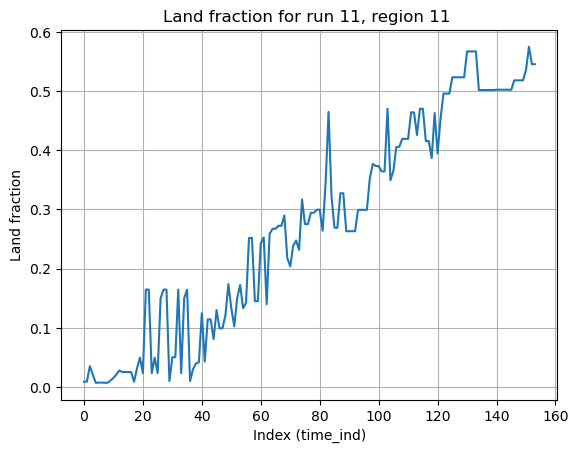

In [ ]:
%matplotlib inline
ages = np.arange(60,-1,-1)
age_ref = np.nanmax(ages)
year_ref = 2020
year_start = year_ref - age_ref
year_end = 2113 # based on maximum life expectancy reported in UNWPP
year_range = np.arange(year_start,year_end+1)

import matplotlib.pyplot as plt

da = ds_lfe_perregion_perrun['landfrac_peryear_perregion_STS_ModAct'].sel(run=11, region=11)

if np.all(np.isnan(da.values)):
    print("Warning: All values are NaN — nothing to plot.")
else:
    plt.plot(np.arange(len(year_range)), da.values)
    plt.xlabel("Index (time_ind)")
    plt.ylabel("Land fraction")
    plt.title("Land fraction for run 11, region 11 ")
    plt.grid()
    plt.show()

#### ds_lfe_perregion

In [ ]:
file_path = data_dir + '{}/{}/ds_lfe_perregion_gmt_{}_{}.pkl'.format('pickles_S2S_v1','heatwavedarea','original','no_rm')
with open(file_path, 'rb') as f: ds_lfe_perregion=pk.load(f)   

print(ds_lfe_perregion['mmm_STS_ModAct'].sel(region=1))

<xarray.DataArray 'mmm_STS_ModAct' (time_ind: 154)>
array([0.01353092, 0.01353092, 0.00346472, 0.01422922, 0.00409871,
       0.0073081 , 0.00426269, 0.00676799, 0.0072232 , 0.0149625 ,
       0.01764701, 0.01422922, 0.0223032 , 0.02796486, 0.01412515,
       0.01412515, 0.01412515, 0.01353092, 0.02245565, 0.00631578,
       0.00620598, 0.01774325, 0.01774325, 0.0196952 , 0.01494356,
       0.01114492, 0.00481413, 0.04190908, 0.03265625, 0.01712602,
       0.00742107, 0.00742107, 0.03604721, 0.0196952 , 0.00475225,
       0.01685749, 0.00633727, 0.02415693, 0.03385047, 0.04914295,
       0.03297523, 0.01027983, 0.03129762, 0.02358135, 0.01888968,
       0.03648269, 0.05381088, 0.02790203, 0.02959836, 0.06074867,
       0.0482865 , 0.04488323, 0.04947035, 0.07179672, 0.07548128,
       0.08103168, 0.05731097, 0.06674395, 0.09260244, 0.09267027,
       0.07016104, 0.05876216, 0.05055033, 0.07742403, 0.07435292,
       0.07523902, 0.05796356, 0.08320497, 0.08560666, 0.08961094,
       0.1

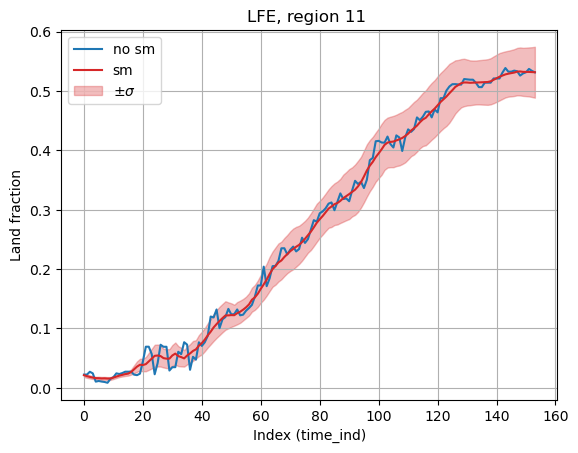

In [ ]:
ds = ds_lfe_perregion['mmm_STS_ModAct'].sel(region=11)
ds_sm = ds_lfe_perregion['mmm_STS_ModAct_sm'].sel(region=11)
std_sm = ds_lfe_perregion['std_STS_ModAct_sm'].sel(region=11)
median_sm = ds_lfe_perregion['median_STS_ModAct_sm'].sel(region=11)

plt.plot(np.arange(len(year_range)), ds,label='no sm')
plt.plot(np.arange(len(year_range)), ds_sm,color='tab:red',label='sm')
plt.fill_between(np.arange(len(year_range)), ds_sm - std_sm/2, ds_sm + std_sm/2, alpha=0.3, label=r'$\pm \sigma$',color='tab:red',lw=1)
#plt.fill_between(np.arange(len(year_range)), ds_sm - median_sm, ds_sm + median_sm, alpha=0.3, label=r'$\pm \sigma$',color='tab:green',lw=1)
plt.xlabel("Index (time_ind)")
plt.ylabel("Land fraction")
plt.title("LFE, region 11 ")
plt.legend()
plt.grid()
plt.show()

In [ ]:
with open(data_dir+'{}/{}/ds_lfe_perregion_gmt_{}_{}.pkl'.format('pickles_S2S_v1','heatwavedarea','original','rm'), 'rb') as f:
                ds_lfe_perregion = pk.load(f)

In [ ]:
print(ds_lfe_perregion['mmm_STS_ModAct_sm'])

<xarray.DataArray 'mmm_STS_ModAct_sm' (region: 12, time_ind: 154)>
array([[0.01948074, 0.01778939, 0.01628206, ..., 0.33055738, 0.32805393,
        0.32471601],
       [0.00916214, 0.00797644, 0.00754207, ..., 0.357912  , 0.35708363,
        0.35597913],
       [0.02729777, 0.0235621 , 0.02165494, ..., 0.44921376, 0.45201609,
        0.45575253],
       ...,
       [0.03459242, 0.03366353, 0.03203883, ..., 0.69425616, 0.6918839 ,
        0.68872088],
       [0.02463337, 0.02331318, 0.02067238, ..., 0.45458194, 0.45375767,
        0.45265863],
       [0.02754287, 0.02522779, 0.02319386, ..., 0.49522438, 0.495443  ,
        0.4957345 ]])
Coordinates:
  * region    (region) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * time_ind  (time_ind) int64 0 1 2 3 4 5 6 7 ... 147 148 149 150 151 152 153
    quantile  float64 0.25


In [ ]:
ds = xr.open_dataset(scripts_dir+"/output/assessment/SPARCCLE_STS/STS_Ren_heatwavedarea_landfraction_exposed_perregion_rm.nc")

print(ds)
print(ds['mmm_STS_Ren_sm'].sel(region=11,time_ind=153))

<xarray.Dataset>
Dimensions:            (region: 12, time_ind: 154)
Coordinates:
  * region             (region) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * time_ind           (time_ind) int64 0 1 2 3 4 5 ... 148 149 150 151 152 153
    quantile           float64 ...
Data variables:
    mmm_STS_Ren        (region, time_ind) float64 ...
    std_STS_Ren        (region, time_ind) float64 ...
    median_STS_Ren     (region, time_ind) float64 ...
    mmm_STS_Ren_sm     (region, time_ind) float64 ...
    std_STS_Ren_sm     (region, time_ind) float64 ...
    median_STS_Ren_sm  (region, time_ind) float64 ...
    lqntl_STS_Ren      (region, time_ind) float64 ...
    uqntl_STS_Ren      (region, time_ind) float64 ...
Attributes:
    README:   \n            This dataset contains the values of the Land Frac...
<xarray.DataArray 'mmm_STS_Ren_sm' ()>
array(0.188999)
Coordinates:
    region    int64 11
    time_ind  int64 153
    quantile  float64 ...


## Land Fraction Exposed (LFE)

### ds_lfe_perregion_perrun

In [ ]:
file_path = data_dir + '{}/{}/ds_lfe_perregion_perrun_gmt_{}_{}.pkl'.format('pickles_S2S_v1','heatwavedarea','original','rm')
with open(file_path, 'rb') as f: ds_lfe_perregion_perrun=pk.load(f)   

print(ds_lfe_perregion_perrun)

<xarray.Dataset>
Dimensions:                                (run: 12, region: 12, time_ind: 154)
Coordinates:
  * run                                    (run) int64 1 2 3 4 5 ... 9 10 11 12
  * region                                 (region) int64 0 1 2 3 ... 8 9 10 11
  * time_ind                               (time_ind) int64 0 1 2 ... 152 153
Data variables:
    landfrac_peryear_perregion_RCP         (run, region, time_ind) float64 0....
    landfrac_peryear_perregion_15          (run, region, time_ind) float64 0....
    landfrac_peryear_perregion_20          (run, region, time_ind) float64 na...
    landfrac_peryear_perregion_NDC         (run, region, time_ind) float64 na...
    landfrac_peryear_perregion_STS_ModAct  (run, region, time_ind) float64 na...
    landfrac_peryear_perregion_STS_Ren     (run, region, time_ind) float64 0....


In [ ]:
ds_lfe_perregion_perrun['landfrac_peryear_perregion_15'].sel(run=1, region=10)

<xarray.DataArray 'landfrac_peryear_perregion_15' (time_ind: 154)>
array([0.01260164, 0.01476521, 0.01476521, 0.01132745, 0.00842813,
       0.01948304, 0.        , 0.04473311, 0.01740083, 0.01054747,
       0.01740083, 0.01476521, 0.01260164, 0.02031331, 0.02031331,
       0.02031331, 0.02031331, 0.02917739, 0.03516335, 0.01976887,
       0.01531844, 0.01531844, 0.07117583, 0.03347724, 0.03347724,
       0.01708406, 0.01531844, 0.07117583, 0.0072461 , 0.03506763,
       0.04571911, 0.00064051, 0.07117583, 0.01531844, 0.10094071,
       0.03506763, 0.04571911, 0.03126152, 0.01252375, 0.02236568,
       0.0099864 , 0.01852254, 0.08630199, 0.08630199, 0.1340093 ,
       0.02408758, 0.02408758, 0.02408758, 0.01775925, 0.03626729,
       0.03626729, 0.06511296, 0.03549664, 0.01984003, 0.08195397,
       0.03699507, 0.0710816 , 0.06810439, 0.06492828, 0.06982593,
       0.04375418, 0.0480249 , 0.05329036, 0.07580085, 0.08049781,
       0.10305533, 0.09918905, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716, 0.06821716,
       0.06821716, 0.06821716, 0.06821716, 0.06821716])
Coordinates:
    run       int64 1
    region    int64 10
  * time_ind  (time_ind) int64 0 1 2 3 4 5 6 7 ... 147 148 149 150 151 152 153

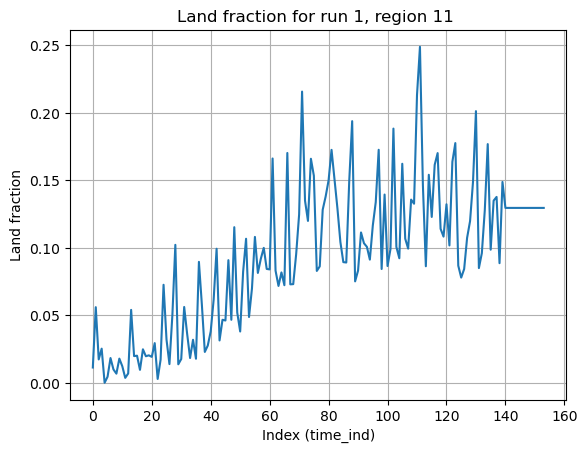

In [ ]:
%matplotlib inline
ages = np.arange(60,-1,-1)
age_ref = np.nanmax(ages)
year_ref = 2020
year_start = year_ref - age_ref
year_end = 2113 # based on maximum life expectancy reported in UNWPP
year_range = np.arange(year_start,year_end+1)

import matplotlib.pyplot as plt

da = ds_lfe_perregion_perrun['landfrac_peryear_perregion_RCP'].sel(run=1, region=11)

if np.all(np.isnan(da.values)):
    print("Warning: All values are NaN — nothing to plot.")
else:
    plt.plot(np.arange(len(year_range)), da.values)
    plt.xlabel("Index (time_ind)")
    plt.ylabel("Land fraction")
    plt.title("Land fraction for run 1, region 11 ")
    plt.grid()
    plt.show()

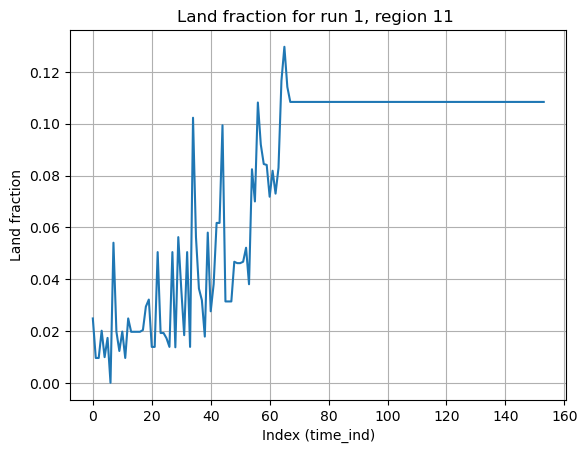

In [ ]:
da = ds_lfe_perregion_perrun['landfrac_peryear_perregion_15'].sel(run=1, region=11)

if np.all(np.isnan(da.values)):
    print("Warning: All values are NaN — nothing to plot.")
else:
    plt.plot(np.arange(len(year_range)), da.values)
    plt.xlabel("Index (time_ind)")
    plt.ylabel("Land fraction")
    plt.title("Land fraction for run 1, region 11 ")
    plt.grid()
    plt.show()

### ds_lfe_perregion

In [ ]:
file_path = data_dir + '{}/{}/ds_lfe_perregion_gmt_{}_{}.pkl'.format('pickles_S2S_v1','burntarea','original','rm')
with open(file_path, 'rb') as f: ds_lfe_perregion=pk.load(f)   

print(ds_lfe_perregion['mmm_STS_ModAct_sm'].sel(region=1))

<xarray.DataArray 'mmm_STS_ModAct_sm' (time_ind: 154)>
array([0.00876899, 0.00860005, 0.00863918, 0.00859413, 0.00869493,
       0.0086431 , 0.00867889, 0.00861938, 0.00851996, 0.0086213 ,
       0.00879185, 0.00898591, 0.00906811, 0.00908541, 0.00903754,
       0.00919176, 0.00926734, 0.00938511, 0.00938013, 0.00928618,
       0.00928847, 0.00923153, 0.00916538, 0.00925796, 0.00929438,
       0.00930776, 0.00940208, 0.00956859, 0.00953389, 0.00960851,
       0.00954006, 0.00962546, 0.00974776, 0.00967635, 0.00974821,
       0.00971514, 0.00957095, 0.00948031, 0.00962239, 0.00969417,
       0.00984079, 0.0098337 , 0.00984248, 0.01000584, 0.01001106,
       0.01002893, 0.01018625, 0.01030906, 0.01033447, 0.01041538,
       0.01039012, 0.01042693, 0.01055837, 0.01071447, 0.01084088,
       0.010959  , 0.01094715, 0.01103409, 0.01120368, 0.01139625,
       0.01165977, 0.01182656, 0.01182783, 0.01180634, 0.01184734,
       0.01202293, 0.01231556, 0.0124012 , 0.01240785, 0.01224967,
       

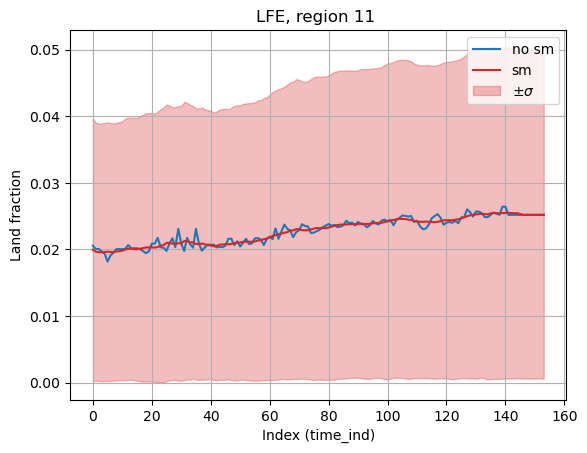

In [ ]:
ds = ds_lfe_perregion['mmm_NDC'].sel(region=11)
ds_sm = ds_lfe_perregion['mmm_NDC_sm'].sel(region=11)
std_sm = ds_lfe_perregion['std_NDC_sm'].sel(region=11)
median_sm = ds_lfe_perregion['median_NDC_sm'].sel(region=11)

plt.plot(np.arange(len(year_range)), ds,label='no sm')
plt.plot(np.arange(len(year_range)), ds_sm,color='tab:red',label='sm')
plt.fill_between(np.arange(len(year_range)), ds_sm - std_sm, ds_sm + std_sm, alpha=0.3, label=r'$\pm \sigma$',color='tab:red',lw=1)
#plt.fill_between(np.arange(len(year_range)), ds_sm - median_sm, ds_sm + median_sm, alpha=0.3, label=r'$\pm \sigma$',color='tab:green',lw=1)
plt.xlabel("Index (time_ind)")
plt.ylabel("Land fraction")
plt.title("LFE, region 11 ")
plt.legend()
plt.grid()
plt.show()

### ds_lfe_percountry

In [ ]:
file_path = data_dir + '{}/{}/ds_lfe_percountry_gmt_{}_{}.pkl'.format('pickles_S2S_v1','heatwavedarea','original','no_rm')
with open(file_path, 'rb') as f: ds_lfe_percountry=pk.load(f)   

print(ds_lfe_percountry['mmm_20_sm'].sel(country='Belgium'))

<xarray.DataArray 'mmm_20_sm' (time_ind: 154)>
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.022033  , 0.022033  , 0.022033  , 0.0264209 , 0.0264209 ,
       0.0264209 , 0.0484539 , 0.0484539 , 0.0528418 , 0.05429394,
       0.03226094, 0.03226094, 0.03226094, 0.03226094, 0.03226094,
       0.03226094, 0.01022794, 0.01022794, 0.00584004, 0.02212718,
       0.05546051, 0.05546051, 0.06087383, 0.06189924, 0.06189924,
       0.06189924, 0.06189924, 0.06189924, 0.06189924, 0.04415996,
       0.01620349, 0.01620349, 0.01079017, 0.00537686, 0.00537686,
       0.00537686, 0.00537686, 0.00537686, 0.01073285, 0.0375214 ,
       0.06726641, 0.09081427, 0.11906544, 0.14731138, 0.15224588,
       0.16154735, 0.16204185, 0.16627154, 0.16286222, 0.13801512,
       0.11022191, 0.09500739, 0.07503223, 0.07470632, 0.08102517,
       0.082487

### ds_regions

In [ ]:
file_path = data_dir + '{}/country/ds_regions.pkl'.format('pickles_S2S_v1')
with open(file_path, 'rb') as f: ds_regions=pk.load(f)   

print(ds_regions['member_countries'].sel(region=7))

<xarray.DataArray 'member_countries' ()>
array(list(['Canada', 'United States']), dtype=object)
Coordinates:
    region   int64 7


## GMT stylized trajectories

### Comparison between S2S and WT

In [ ]:
with open(data_dir+'temperature_trajectories_SR15/df_GMT_strj.pkl', 'rb') as f:
            df_GMT_strj_S2S = pk.load(f)

GMT_BE_WT = loadmat(scripts_dir+'/references/lifetime_exposure_wim/lifetime_exposure_wim_v1/GMT_BE.mat',squeeze_me=True)

GMT_BE_WT = GMT_BE_WT['GMT_BE']

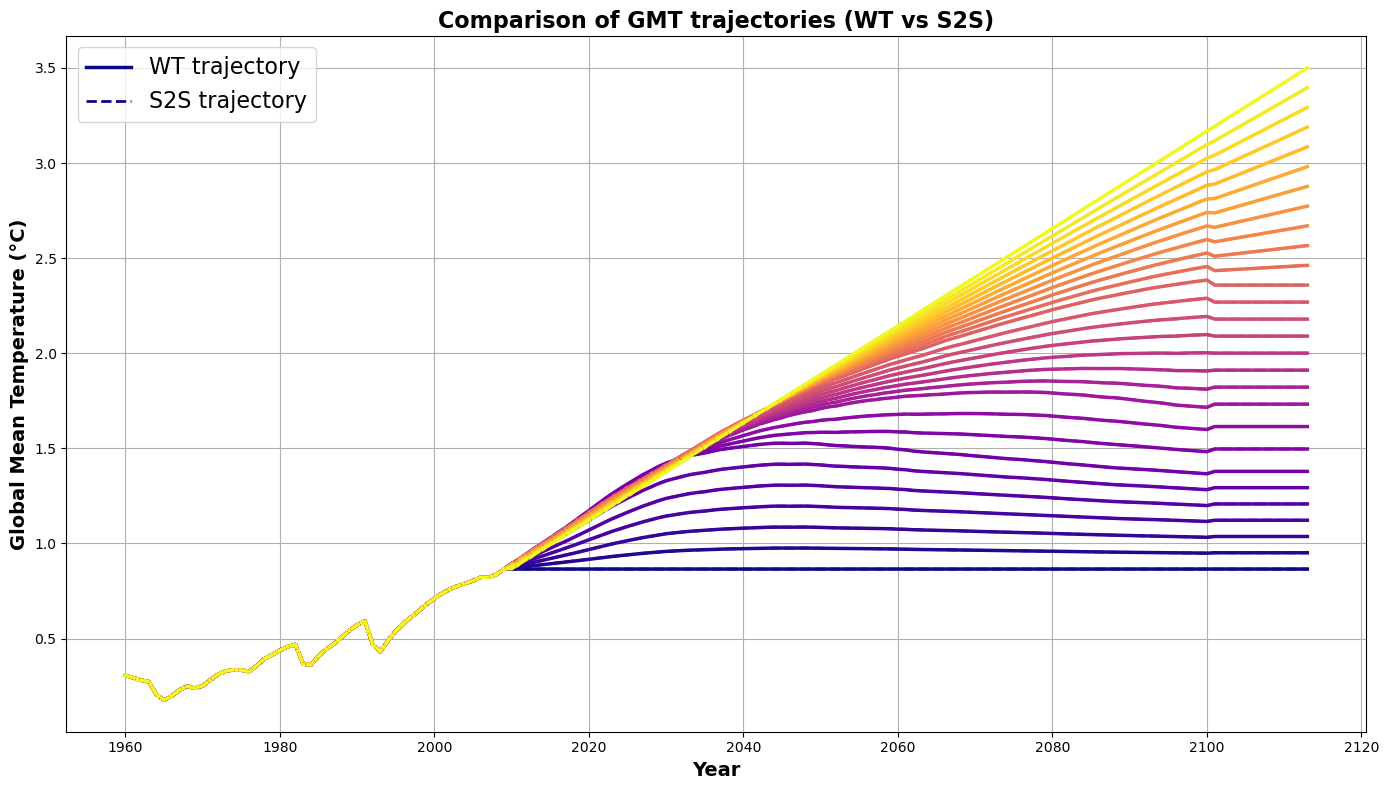

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

plt.close('all')

years = df_GMT_strj_S2S.index

# Nouvelle palette : 'plasma' (bleu → jaune → rouge)
colors = cm.plasma(np.linspace(0, 1, df_GMT_strj_S2S.shape[1]))

plt.figure(figsize=(14, 8))

# Tracer WT (trait plein) - légende uniquement pour le premier
for i in range(df_GMT_strj_S2S.shape[1]):
    plt.plot(
        years,
        GMT_BE_WT[:, i],
        linestyle='-',
        color=colors[i],
        lw=2.5,
        label='WT trajectory' if i == 0 else None
    )

# Tracer S2S (pointillé) - légende uniquement pour le premier
for i in range(df_GMT_strj_S2S.shape[1]):
    plt.plot(
        years,
        df_GMT_strj_S2S.iloc[:, i],
        linestyle='--',
        color=colors[i],
        lw=2,
        label='S2S trajectory' if i == 0 else None
    )

plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Global Mean Temperature (°C)', fontsize=14, fontweight='bold')
plt.title('Comparison of GMT trajectories (WT vs S2S)', fontsize=16, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=16)
plt.show()


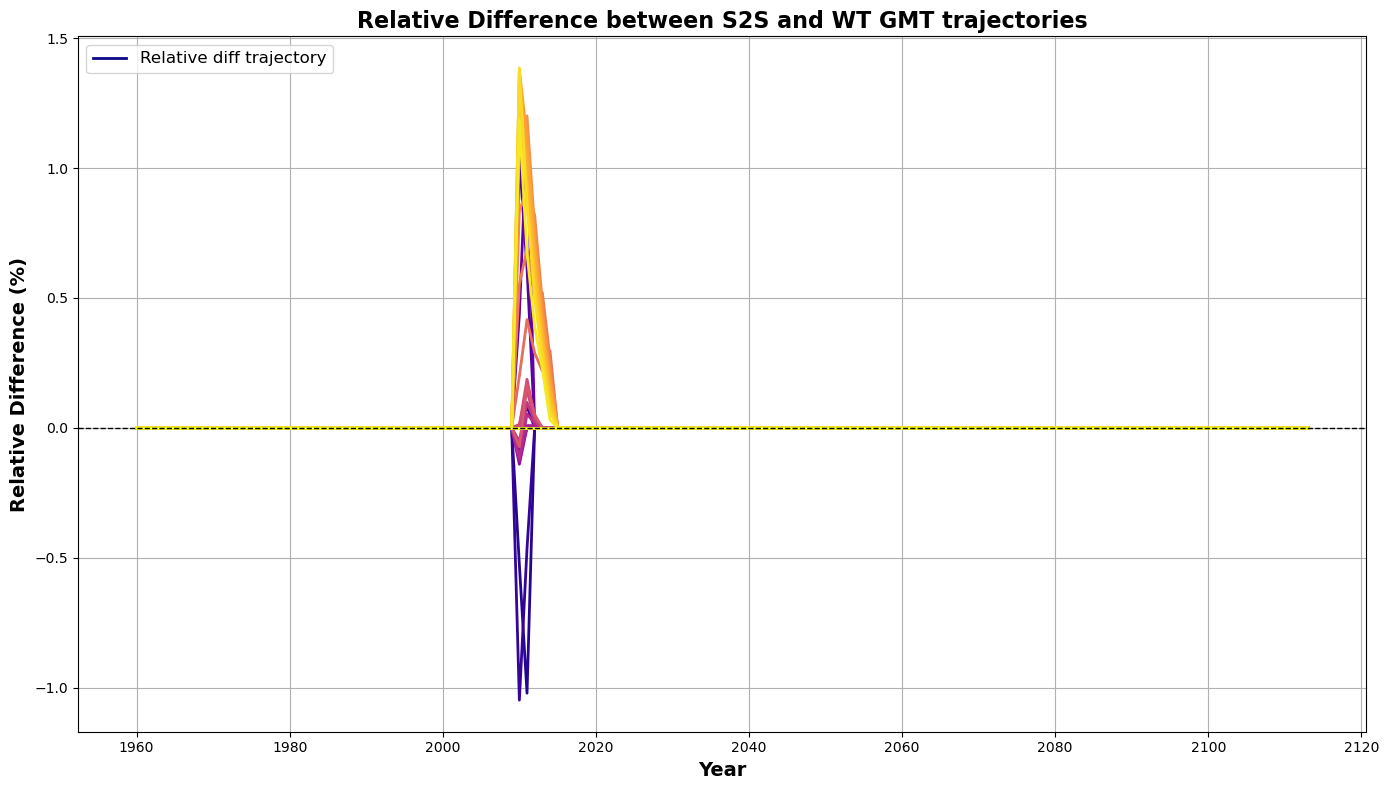

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

plt.close('all')

# Définir les années
years = df_GMT_strj_S2S.index

# Vérifier que les shapes sont compatibles
assert np.shape(GMT_BE_WT) == np.shape(df_GMT_strj_S2S), "Shapes of GMT_BE_WT and df_GMT_strj_S2S do not match."

# Calculer la différence relative (%) entre chaque paire
relative_diff = (df_GMT_strj_S2S.values - GMT_BE_WT) / GMT_BE_WT * 100

# Définir la colormap
colors = cm.plasma(np.linspace(0, 1, df_GMT_strj_S2S.shape[1]))

plt.figure(figsize=(14, 8))

# Tracer chaque différence relative
for i in range(df_GMT_strj_S2S.shape[1]):
    plt.plot(
        years,
        relative_diff[:, i],
        color=colors[i],
        lw=2,
        label='Relative diff trajectory' if i == 0 else None  # Légende une seule fois
    )

plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Relative Difference (%)', fontsize=14, fontweight='bold')
plt.title('Relative Difference between S2S and WT GMT trajectories', fontsize=16, fontweight='bold')
plt.axhline(0, color='black', linestyle='--', lw=1)  # ligne horizontale à 0 pour référence
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=12, loc='upper left')
plt.show()


## GMT Remapping 

In [ ]:
with open(data_dir+'{}/{}/isimip_metadata_{}_{}_{}.pkl'.format('pickles_S2S_v1','tropicalcyclonedarea','tropicalcyclonedarea','original','no_rm'), 'rb') as f:
            d_isimip_meta_original_no_rm =pk.load(f)  


S2S_strj_valid = []

for i in range(1, 13):
    traj = d_isimip_meta_original_no_rm[i]['GMT_strj_valid']
    S2S_strj_valid.append(traj)

S2S_strj_valid = np.vstack(S2S_strj_valid)

print(S2S_strj_valid)
print(np.shape(S2S_strj_valid))

S2S_strj_maxdiff = []

for i in range(1, 13):
    traj = d_isimip_meta_original_no_rm[i]['GMT_strj_maxdiff']
    S2S_strj_maxdiff.append(traj)

S2S_strj_maxdiff = np.vstack(S2S_strj_maxdiff)

print(S2S_strj_maxdiff)
print(np.shape(S2S_strj_maxdiff))

print(np.shape(d_isimip_meta_original_no_rm[1]['ind_RCP2GMT_strj']))

# S2S_ind_RCP2GMT_strj = []

# for i in range(1, 13):
#     indices = d_isimip_meta_original_no_rm[i]['ind_RCP2GMT_strj']
#     S2S_ind_RCP2GMT_strj.append(indices)

# S2S_ind_RCP2GMT_strj = np.vstack(S2S_ind_RCP2GMT_strj)

# print(S2S_ind_RCP2GMT_strj)
# print(np.shape(S2S_ind_RCP2GMT_strj))

[[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
(12, 28)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
WT_ind_RCP2GMT_BE = loadmat(scripts_dir+'/references/lifetime_exposure_wim/lifetime_exposure_wim_v1/ind_RCP2GMT_BE.mat',squeeze_me=True)

WT_ind_RCP2GMT_BE = WT_ind_RCP2GMT_BE['ind_RCP2GMT_BE']

print(WT_ind_RCP2GMT_BE)
print(np.shape(WT_ind_RCP2GMT_BE))

WT_RCP2GMT_diff_BE = loadmat(scripts_dir+'/references/lifetime_exposure_wim/lifetime_exposure_wim_v1/RCP2GMT_diff_BE.mat',squeeze_me=True)

WT_RCP2GMT_diff_BE = WT_RCP2GMT_diff_BE['RCP2GMT_diff_BE']

print(WT_RCP2GMT_diff_BE)
print(np.shape(WT_RCP2GMT_diff_BE))

[[ 26  26  34 ...  37  37  37]
 [ 26  26  34 ...  51  51  51]
 [ 26  26  34 ...  84  84  84]
 ...
 [ 26  26  34 ... 111 111 111]
 [ 26  26  34 ... 111 111 111]
 [ 26  26  34 ... 111 111 111]]
(28, 154)
[[1.24197456e-02 7.25983303e-04 1.01656301e-03 ... 7.16654021e-03
  7.16654021e-03 7.16654021e-03]
 [1.24197456e-02 7.25983303e-04 1.01656301e-03 ... 9.73334079e-03
  9.73334079e-03 9.73334079e-03]
 [1.24197456e-02 7.25983303e-04 1.01656301e-03 ... 1.30014136e-03
  1.30014136e-03 1.30014136e-03]
 ...
 [1.24197456e-02 7.25983303e-04 1.01656301e-03 ... 1.55017501e+00
  1.57110157e+00 1.59202814e+00]
 [1.24197456e-02 7.25983303e-04 1.01656301e-03 ... 1.64930471e+00
  1.67255645e+00 1.69580819e+00]
 [1.24197456e-02 7.25983303e-04 1.01656301e-03 ... 1.74843442e+00
  1.77401133e+00 1.79958824e+00]]
(28, 154)
